In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import joblib

# 1. Data Loading and Preparation
def load_time_series_data():
    """Load data where each test has one time series of temperatures"""
    summary_df = pd.read_csv('all.csv')
    test_data = []
    
    # Load each test file and its parameters
    for i in range(1, 26):
        try:
            filename = f'csv_ave/{i}_ave.csv'
            df = pd.read_csv(filename, header=1)
            test_params = summary_df.iloc[i-1][['Fb_set\n[kN]', 'v_set\n[km/h]', 'μ_m']].values
            temperature_series = df.iloc[:, 3].values  # Assuming temperature is in column 3
            
            test_data.append({
                'Fb_set': test_params[0],
                'v_set': test_params[1],
                'μ_m': test_params[2],
                'temperature_series': temperature_series,
                'series_length': len(temperature_series)
            })
        except FileNotFoundError:
            continue
    
    return test_data

# Load data
test_data = load_time_series_data()

# Find the maximum length to pad/truncate all series to same length
max_length = max([d['series_length'] for d in test_data])

# Prepare data arrays
X = []
y = []

for test in test_data:
    # Input features
    X.append([test['Fb_set'], test['v_set'], test['μ_m']])
    
    # Temperature series (pad shorter series with last value)
    temp_series = test['temperature_series']
    if len(temp_series) < max_length:
        padded = np.pad(temp_series, 
                       (0, max_length - len(temp_series)), 
                       mode='edge')  # Pad with last value
    else:
        padded = temp_series[:max_length]  # Truncate if longer
    y.append(padded)

X = np.array(X)
y = np.array(y)

In [39]:
print(X.shape)
print(y.shape)

(12, 3)
(12, 43663)


In [43]:
print(X)

[[ 23.     50.      0.408]
 [ 23.     80.      0.383]
 [ 23.    120.      0.374]
 [ 23.    160.      0.376]
 [ 23.    200.      0.381]
 [ 23.    250.      0.383]
 [ 23.     50.      0.397]
 [ 23.     80.      0.379]
 [ 23.    120.      0.38 ]
 [ 23.    160.      0.387]
 [ 23.    200.      0.396]
 [ 23.    250.      0.392]]


In [50]:
# Split into train and test sets (keeping each test's series together)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Normalize features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Normalize targets (per time step)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# 2. Model Definition
def build_time_series_model(input_shape, output_length):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(output_length)  # Output matches time series length
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

model = build_time_series_model((X_train.shape[1],), max_length)
model.summary()

# 3. Training Configuration
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'best_time_series_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min')

# 4. Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, checkpoint],
    verbose=1)

/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 43663)          │       392,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,567 (1.51 MB)

 Trainable params: 395,567 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.9154 - mae: 0.8160

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - loss: 0.9154 - mae: 0.8160 - val_loss: 1.3431 - val_mae: 1.0613
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9140 - mae: 0.8155 - val_loss: 1.3469 - val_mae: 1.0599
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9124 - mae: 0.8146 - val_loss: 1.3498 - val_mae: 1.0577
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9070 - mae: 0.8115 - val_loss: 1.3498 - val_mae: 1.0530
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9127 - mae: 0.8150 - val_loss: 1.3492 - val_mae: 1.0474
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9041 - mae: 0.8117 - val_loss: 1.3465 - val_mae: 1.0402
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8928 - mae: 0.8072

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8928 - mae: 0.8072 - val_loss: 1.3386 - val_mae: 1.0284
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8778 - mae: 0.7998

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8778 - mae: 0.7998 - val_loss: 1.3255 - val_mae: 1.0114
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8778 - mae: 0.8021

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8778 - mae: 0.8021 - val_loss: 1.3097 - val_mae: 0.9912
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8777 - mae: 0.8019

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8777 - mae: 0.8019 - val_loss: 1.2918 - val_mae: 0.9669
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8930 - mae: 0.8112

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8930 - mae: 0.8112 - val_loss: 1.2765 - val_mae: 0.9428
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8527 - mae: 0.7913

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8527 - mae: 0.7913 - val_loss: 1.2592 - val_mae: 0.9159
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8959 - mae: 0.8152

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8959 - mae: 0.8152 - val_loss: 1.2451 - val_mae: 0.8938
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8532 - mae: 0.7951

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8532 - mae: 0.7951 - val_loss: 1.2288 - val_mae: 0.8695
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8291 - mae: 0.7788

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8291 - mae: 0.7788 - val_loss: 1.2092 - val_mae: 0.8401
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8378 - mae: 0.7982

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8378 - mae: 0.7982 - val_loss: 1.1892 - val_mae: 0.8091
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7993 - mae: 0.7722

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7993 - mae: 0.7722 - val_loss: 1.1667 - val_mae: 0.7819
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7711 - mae: 0.7581

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7711 - mae: 0.7581 - val_loss: 1.1428 - val_mae: 0.7864
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7460 - mae: 0.7273

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7460 - mae: 0.7273 - val_loss: 1.1201 - val_mae: 0.7967
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7399 - mae: 0.7407

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7399 - mae: 0.7407 - val_loss: 1.0924 - val_mae: 0.8032
Epoch 21/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8293 - mae: 0.7840

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8293 - mae: 0.7840 - val_loss: 1.0593 - val_mae: 0.7982
Epoch 22/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6850 - mae: 0.6648

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6850 - mae: 0.6648 - val_loss: 1.0134 - val_mae: 0.7740
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7377 - mae: 0.6955

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7377 - mae: 0.6955 - val_loss: 0.9686 - val_mae: 0.7504
Epoch 24/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6450 - mae: 0.6622

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6450 - mae: 0.6622 - val_loss: 0.9352 - val_mae: 0.7550
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7069 - mae: 0.7004

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7069 - mae: 0.7004 - val_loss: 0.9060 - val_mae: 0.7672
Epoch 26/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5495 - mae: 0.5730

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5495 - mae: 0.5730 - val_loss: 0.8939 - val_mae: 0.7885
Epoch 27/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7585 - mae: 0.7141 - val_loss: 0.9131 - val_mae: 0.8305
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6810 - mae: 0.6335 - val_loss: 0.9390 - val_mae: 0.8654
Epoch 29/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4937 - mae: 0.5370 - val_loss: 0.9880 - val_mae: 0.9097
Epoch 30/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5673 - mae: 0.5973 - val_loss: 1.1348 - val_mae: 1.0010
Epoch 31/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5512 - mae: 0.6171 - val_loss: 1.4589 - val_mae: 1.1535
Epoch 32/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4627 - mae: 0.5455 - val_loss: 1.9540 - val_mae: 1.3338
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3531 - mae: 0.4611 - val_loss: 2.2826 - val_mae: 1.4341
Epoch 34/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4885 - mae: 0.56

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2995 - mae: 0.4705 - val_loss: 0.8739 - val_mae: 0.8786
Epoch 39/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6554 - mae: 0.6627

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6554 - mae: 0.6627 - val_loss: 0.8444 - val_mae: 0.8621
Epoch 40/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4162 - mae: 0.5362 - val_loss: 0.9213 - val_mae: 0.9128
Epoch 41/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2672 - mae: 0.4541 - val_loss: 1.1033 - val_mae: 1.0149
Epoch 42/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4252 - mae: 0.5420 - val_loss: 1.4084 - val_mae: 1.1556
Epoch 43/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3299 - mae: 0.4634 - val_loss: 1.7808 - val_mae: 1.2979
Epoch 44/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2323 - mae: 0.3575 - val_loss: 1.9981 - val_mae: 1.3713
Epoch 45/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2191 - mae: 0.3994 - val_loss: 2.1369 - val_mae: 1.4129
Epoch 46/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5219 - mae: 0.5878 - val_loss: 2.0424 - val_mae: 1.3833
Epoch 47/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4151 - mae: 0.51

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1694 - mae: 0.3533 - val_loss: 0.8325 - val_mae: 0.8622
Epoch 52/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4615 - mae: 0.5559

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4615 - mae: 0.5559 - val_loss: 0.8119 - val_mae: 0.8469
Epoch 53/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2687 - mae: 0.4288 - val_loss: 0.8636 - val_mae: 0.8813
Epoch 54/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1663 - mae: 0.3437 - val_loss: 0.9480 - val_mae: 0.9313
Epoch 55/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3653 - mae: 0.4427 - val_loss: 1.0775 - val_mae: 1.0008
Epoch 56/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3026 - mae: 0.4275 - val_loss: 1.2188 - val_mae: 1.0709
Epoch 57/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3221 - mae: 0.4737 - val_loss: 1.3758 - val_mae: 1.1443
Epoch 58/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2067 - mae: 0.3825 - val_loss: 1.5442 - val_mae: 1.2176
Epoch 59/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5407 - mae: 0.4962 - val_loss: 1.4786 - val_mae: 1.1892
Epoch 60/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1793 - mae: 0.31


Evaluating on test data:
Test MSE: 6.5909, Test MAE: 1.3421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/Users/yanjun/Documents/apps/miniconda3/envs/dd2421/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


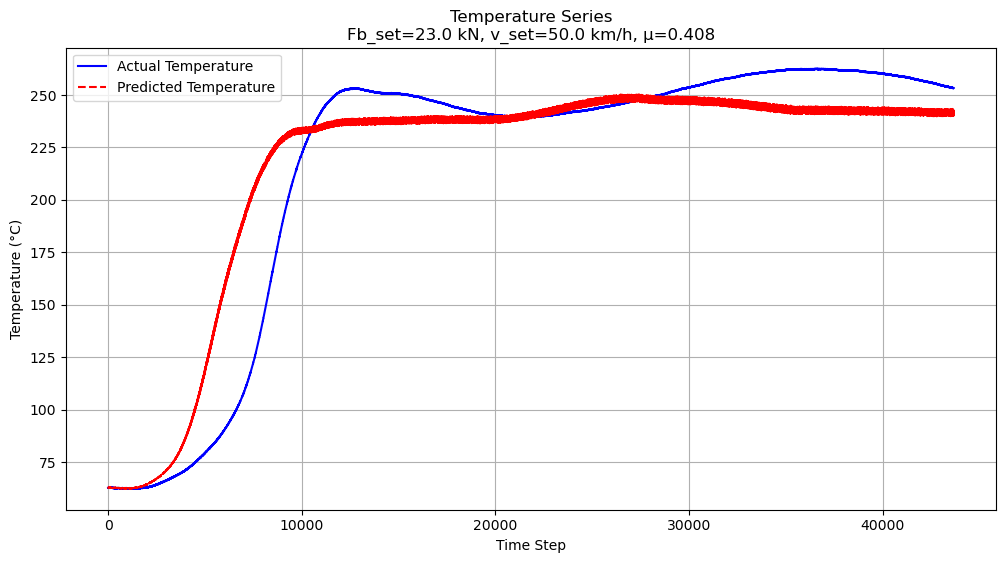

In [53]:
# 5. Evaluate the Model
print("\nEvaluating on test data:")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Save the model and scalers
model.save('brake_temp_time_series_model.keras')
joblib.dump(scaler_X, 'scaler_X_time_series.pkl')
joblib.dump(scaler_y, 'scaler_y_time_series.pkl')

# 6. Prediction Function
def predict_temperature_series(Fb_set, v_set, mu_m):
    """Predict the full temperature time series for given parameters"""
    # Load model and scalers
    model = keras.models.load_model('brake_temp_time_series_model.keras')
    scaler_X = joblib.load('scaler_X_time_series.pkl')
    scaler_y = joblib.load('scaler_y_time_series.pkl')
    
    # Prepare input
    input_data = np.array([[Fb_set, v_set, mu_m]])
    input_data = scaler_X.transform(input_data)
    
    # Predict
    prediction = model.predict(input_data)
    prediction = scaler_y.inverse_transform(prediction)
    
    return prediction[0]  # Return the full time series

# 7. Visualization
def plot_temperature_series(Fb_set, v_set, mu_m):
    """Plot the predicted temperature series"""
    # Get prediction
    pred_temp = predict_temperature_series(Fb_set, v_set, mu_m)
    
    # Find the actual data if available
    actual_temp = None
    for test in test_data:
        if (test['Fb_set'] == Fb_set and 
            test['v_set'] == v_set and 
            test['μ_m'] == mu_m):
            actual_temp = test['temperature_series']
            break
    
    # Create time axis
    time_steps = np.arange(len(pred_temp))
    
    # Plot
    plt.figure(figsize=(12, 6))
    if actual_temp is not None:
        plt.plot(np.linspace(0, len(pred_temp), len(actual_temp)), 
                actual_temp, 'b-', label='Actual Temperature')
    plt.plot(time_steps, pred_temp, 'r--', label='Predicted Temperature')
    
    plt.title(f'Temperature Series\nFb_set={Fb_set} kN, v_set={v_set} km/h, μ={mu_m}')
    plt.xlabel('Time Step')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
if len(test_data) > 0:
    sample_test = test_data[0]
    plot_temperature_series(sample_test['Fb_set'], 
                          sample_test['v_set'], 
                          sample_test['μ_m'])